# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
import os
import time
# wait_to_make = "trained_list/deberta-multidocat.txt"
# count = 0
# while 1:
#     if os.path.exists(wait_to_make):
#         break
#     print(f'sleep {count} h')
#     time.sleep(3600)
#     count+=1
    
local = True

In [2]:
EXP_NAME = "roberta-large"


In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [4]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime
if local:
    INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'
else:
    INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'

OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [5]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    # model="microsoft/deberta-v3-large"
    model = "roberta-large"
    # size = "large
    # model = f"{model}-{size}"
    if "small" in model:
        hidden_state = hiddden_state_fix = 512
    elif "base" in model or "medium" in model:
        hidden_state = hiddden_state_fix = 768
    elif "large" in model:
        hidden_state = hiddden_state_fix = 1024
    elif "xlarge" in model:
        hidden_state =  1536
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=6
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=8
    pass_fold = [0,1]
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[i for i in range(n_fold)]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [6]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [7]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = torch.device('cpu')
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.6
transformers.__version__: 4.17.0
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [10]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [11]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [12]:
pad = "</s>"#"[SEP]"
train['text'] = train['anchor'] + pad + train['target'] +pad  + train['context_text']
test['text'] = test['anchor'] + pad + test['target'] +pad  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement</s>abatement of pollution</s>HUMAN N...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement</s>act of abating</s>HUMAN NECESSITI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement</s>active catalyst</s>HUMAN NECESSIT...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement</s>eliminating process</s>HUMAN NECE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement</s>forest region</s>HUMAN NECESSITIE...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum</s>inorganic photoconductor drum</s>P...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow</s>altering gas flow</s>MECHAN...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion</s>lower locating</s>PERFORMING...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component</s>upper portion</s>TEXTILES; PA...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation</s>artificial neural networ...


# EDA

<AxesSubplot:>

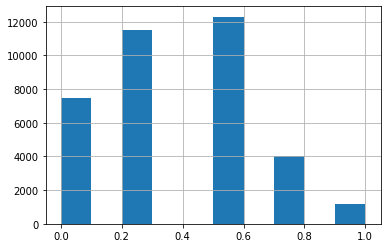

In [13]:
train['score'].hist()

In [14]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [15]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [16]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [17]:
# !pip install --no-cache-dir sentencepiece

In [18]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



# Dataset

In [19]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 175


In [20]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset

torch.__version__: 1.9.0+cu111


In [21]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [22]:
# # ====================================================
# # Model
# # ====================================================
# class CustomModel(nn.Module):
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
#         self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
#         self._init_weights(self.fc)
#         self.attention = nn.Sequential(
#             nn.Linear(self.config.hidden_size, 512),
#             nn.Tanh(),
#             nn.Linear(512, 1),
#             nn.Softmax(dim=1)
#         )
#         self._init_weights(self.attention)
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         last_hidden_states = outputs[0]
#         # feature = torch.mean(last_hidden_states, 1)
#         weights = self.attention(last_hidden_states)
#         feature = torch.sum(weights * last_hidden_states, dim=1)
#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         output = self.fc(self.fc_dropout(feature))
#         return output
    


In [23]:
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self.fc_dropout = nn.Dropout(0.1)
        
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        feature = self.fc_dropout(feature)
        output = self.fc(feature)
        
        return output


# Helpler functions

In [24]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [25]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):
#     LOGGER.info(f"========== fold: {fold} training ==========")

#     # ====================================================
#     # loader
#     # ====================================================
#     train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds['score'].values
    
#     train_dataset = TrainDataset(CFG, train_folds)
#     valid_dataset = TrainDataset(CFG, valid_folds)

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=True,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [26]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.pass_fold:
                continue
               # print（f”￥０r３３［３８；５；４０m＝＝＝＝＝＝＝＝＝＝ this fold is pass ￥ontinue
            LOGGER.info(f"========== fold: {fold} training ==========")
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 2 training ==========


========== fold: 2 training ==========


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3419] Elapsed 0m 1s (remain 62m 36s) Loss: 0.8625(0.8625) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 38s (remain 21m 3s) Loss: 0.5163(0.6702) Grad: 16051.7432  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 16s (remain 20m 20s) Loss: 0.6519(0.6577) Grad: 16845.2969  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 1m 54s (remain 19m 42s) Loss: 0.7138(0.6537) Grad: 5173.3403  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 2m 32s (remain 19m 5s) Loss: 0.6023(0.6495) Grad: 10282.1357  LR: 0.00001998  
Epoch: [1][500/3419] Elapsed 3m 10s (remain 18m 27s) Loss: 0.5720(0.6490) Grad: 13339.5732  LR: 0.00001997  
Epoch: [1][600/3419] Elapsed 3m 48s (remain 17m 49s) Loss: 0.6544(0.6503) Grad: 24223.7773  LR: 0.00001996  
Epoch: [1][700/3419] Elapsed 4m 26s (remain 17m 11s) Loss: 0.6245(0.6502) Grad: 14682.5479  LR: 0.00001994  
Epoch: [1][800/3419] Elapsed 5m 4s (remain 16m 35s) Loss: 0.7712(0.6486) Grad: 13855.1680  LR: 0.00001992  
Epoch: [1][900/3419] Elapsed 5m 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 51s) Loss: 0.6282(0.6282) 
EVAL: [100/1140] Elapsed 0m 12s (remain 2m 6s) Loss: 0.6951(0.6578) 
EVAL: [200/1140] Elapsed 0m 24s (remain 1m 53s) Loss: 0.6449(0.6521) 
EVAL: [300/1140] Elapsed 0m 36s (remain 1m 41s) Loss: 0.7786(0.6535) 
EVAL: [400/1140] Elapsed 0m 48s (remain 1m 29s) Loss: 0.6783(0.6573) 
EVAL: [500/1140] Elapsed 1m 0s (remain 1m 17s) Loss: 0.6616(0.6529) 
EVAL: [600/1140] Elapsed 1m 12s (remain 1m 5s) Loss: 0.6783(0.6530) 
EVAL: [700/1140] Elapsed 1m 24s (remain 0m 52s) Loss: 0.6282(0.6536) 
EVAL: [800/1140] Elapsed 1m 36s (remain 0m 40s) Loss: 0.6115(0.6533) 
EVAL: [900/1140] Elapsed 1m 48s (remain 0m 28s) Loss: 0.6449(0.6535) 
EVAL: [1000/1140] Elapsed 2m 0s (remain 0m 16s) Loss: 0.6282(0.6546) 
EVAL: [1100/1140] Elapsed 2m 12s (remain 0m 4s) Loss: 0.7452(0.6547) 


Epoch 1 - avg_train_loss: 0.6489  avg_val_loss: 0.6547  time: 1453s
Epoch 1 - Score: 0.0356
Epoch 1 - Save Best Score: 0.0356 Model


EVAL: [1139/1140] Elapsed 2m 17s (remain 0m 0s) Loss: 0.7508(0.6547) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 35m 27s) Loss: 0.6885(0.6885) Grad: 41477.7266  LR: 0.00001866  
Epoch: [2][100/3419] Elapsed 0m 39s (remain 21m 30s) Loss: 0.6287(0.6618) Grad: 7295.5166  LR: 0.00001858  
Epoch: [2][200/3419] Elapsed 1m 18s (remain 20m 50s) Loss: 0.5902(0.6548) Grad: 11577.5801  LR: 0.00001850  
Epoch: [2][300/3419] Elapsed 1m 56s (remain 20m 11s) Loss: 0.7390(0.6573) Grad: 19261.6270  LR: 0.00001842  
Epoch: [2][400/3419] Elapsed 2m 35s (remain 19m 32s) Loss: 0.6433(0.6566) Grad: 24636.7969  LR: 0.00001834  
Epoch: [2][500/3419] Elapsed 3m 14s (remain 18m 53s) Loss: 0.7512(0.6551) Grad: 19291.3828  LR: 0.00001825  
Epoch: [2][600/3419] Elapsed 3m 53s (remain 18m 14s) Loss: 0.6442(0.6550) Grad: 11579.0508  LR: 0.00001816  
Epoch: [2][700/3419] Elapsed 4m 32s (remain 17m 35s) Loss: 0.7302(0.6552) Grad: 16964.1387  LR: 0.00001808  
Epoch: [2][800/3419] Elapsed 5m 10s (remain 16m 54s) Loss: 0.6451(0.6554) Grad: 7333.9731  LR: 0.00001798  
Epoch: [2][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 33s) Loss: 0.6241(0.6241) 
EVAL: [100/1140] Elapsed 0m 12s (remain 2m 3s) Loss: 0.7019(0.6586) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 51s) Loss: 0.6436(0.6519) 
EVAL: [300/1140] Elapsed 0m 35s (remain 1m 39s) Loss: 0.7992(0.6536) 
EVAL: [400/1140] Elapsed 0m 47s (remain 1m 28s) Loss: 0.6825(0.6579) 
EVAL: [500/1140] Elapsed 0m 59s (remain 1m 16s) Loss: 0.6630(0.6528) 
EVAL: [600/1140] Elapsed 1m 11s (remain 1m 4s) Loss: 0.6825(0.6529) 
EVAL: [700/1140] Elapsed 1m 23s (remain 0m 52s) Loss: 0.6241(0.6536) 
EVAL: [800/1140] Elapsed 1m 36s (remain 0m 40s) Loss: 0.6046(0.6533) 
EVAL: [900/1140] Elapsed 1m 48s (remain 0m 28s) Loss: 0.6436(0.6535) 
EVAL: [1000/1140] Elapsed 2m 0s (remain 0m 16s) Loss: 0.6241(0.6548) 
EVAL: [1100/1140] Elapsed 2m 12s (remain 0m 4s) Loss: 0.7603(0.6549) 


Epoch 2 - avg_train_loss: 0.6548  avg_val_loss: 0.6549  time: 1458s
Epoch 2 - Score: 0.0365
Epoch 2 - Save Best Score: 0.0365 Model


EVAL: [1139/1140] Elapsed 2m 16s (remain 0m 0s) Loss: 0.7668(0.6549) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 39m 7s) Loss: 0.6432(0.6432) Grad: 23994.8867  LR: 0.00001500  
Epoch: [3][100/3419] Elapsed 0m 38s (remain 21m 11s) Loss: 0.7007(0.6592) Grad: 20594.2090  LR: 0.00001487  
Epoch: [3][200/3419] Elapsed 1m 17s (remain 20m 34s) Loss: 0.6605(0.6592) Grad: 9860.1309  LR: 0.00001473  
Epoch: [3][300/3419] Elapsed 1m 55s (remain 20m 1s) Loss: 0.6421(0.6583) Grad: 3158.7239  LR: 0.00001460  
Epoch: [3][400/3419] Elapsed 2m 34s (remain 19m 22s) Loss: 0.6049(0.6580) Grad: 4784.8164  LR: 0.00001446  
Epoch: [3][500/3419] Elapsed 3m 12s (remain 18m 43s) Loss: 0.5680(0.6584) Grad: 18820.2383  LR: 0.00001432  
Epoch: [3][600/3419] Elapsed 3m 51s (remain 18m 5s) Loss: 0.7106(0.6573) Grad: 13200.0342  LR: 0.00001418  
Epoch: [3][700/3419] Elapsed 4m 29s (remain 17m 26s) Loss: 0.6254(0.6570) Grad: 2244.1582  LR: 0.00001404  
Epoch: [3][800/3419] Elapsed 5m 8s (remain 16m 49s) Loss: 0.6848(0.6560) Grad: 7537.0767  LR: 0.00001390  
Epoch: [3][900/3419] Elapsed 5m

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 36s) Loss: 0.6264(0.6264) 
EVAL: [100/1140] Elapsed 0m 12s (remain 2m 5s) Loss: 0.6974(0.6579) 
EVAL: [200/1140] Elapsed 0m 24s (remain 1m 52s) Loss: 0.6442(0.6518) 
EVAL: [300/1140] Elapsed 0m 35s (remain 1m 40s) Loss: 0.7862(0.6533) 
EVAL: [400/1140] Elapsed 0m 47s (remain 1m 28s) Loss: 0.6797(0.6573) 
EVAL: [500/1140] Elapsed 0m 59s (remain 1m 16s) Loss: 0.6619(0.6527) 
EVAL: [600/1140] Elapsed 1m 11s (remain 1m 4s) Loss: 0.6797(0.6528) 
EVAL: [700/1140] Elapsed 1m 23s (remain 0m 52s) Loss: 0.6265(0.6534) 
EVAL: [800/1140] Elapsed 1m 35s (remain 0m 40s) Loss: 0.6087(0.6531) 
EVAL: [900/1140] Elapsed 1m 47s (remain 0m 28s) Loss: 0.6442(0.6533) 
EVAL: [1000/1140] Elapsed 1m 59s (remain 0m 16s) Loss: 0.6264(0.6545) 
EVAL: [1100/1140] Elapsed 2m 11s (remain 0m 4s) Loss: 0.7507(0.6546) 


Epoch 3 - avg_train_loss: 0.6551  avg_val_loss: 0.6546  time: 1453s
Epoch 3 - Score: 0.0761
Epoch 3 - Save Best Score: 0.0761 Model


EVAL: [1139/1140] Elapsed 2m 16s (remain 0m 0s) Loss: 0.7566(0.6546) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 39m 1s) Loss: 0.5705(0.5705) Grad: 47315.7031  LR: 0.00001000  
Epoch: [4][100/3419] Elapsed 0m 38s (remain 21m 19s) Loss: 0.6423(0.6424) Grad: 12796.0771  LR: 0.00000985  
Epoch: [4][200/3419] Elapsed 1m 17s (remain 20m 38s) Loss: 0.5919(0.6525) Grad: 12231.9160  LR: 0.00000969  
Epoch: [4][300/3419] Elapsed 1m 55s (remain 20m 1s) Loss: 0.7021(0.6523) Grad: 12861.6201  LR: 0.00000954  
Epoch: [4][400/3419] Elapsed 2m 34s (remain 19m 22s) Loss: 0.6459(0.6533) Grad: 5334.8833  LR: 0.00000939  
Epoch: [4][500/3419] Elapsed 3m 12s (remain 18m 43s) Loss: 0.7563(0.6535) Grad: 29893.2090  LR: 0.00000924  
Epoch: [4][600/3419] Elapsed 3m 51s (remain 18m 4s) Loss: 0.6244(0.6531) Grad: 13840.7891  LR: 0.00000908  
Epoch: [4][700/3419] Elapsed 4m 29s (remain 17m 26s) Loss: 0.6817(0.6530) Grad: 5734.8096  LR: 0.00000893  
Epoch: [4][800/3419] Elapsed 5m 8s (remain 16m 47s) Loss: 0.6434(0.6528) Grad: 3659.0730  LR: 0.00000878  
Epoch: [4][900/3419] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 32s) Loss: 0.6257(0.6257) 
EVAL: [100/1140] Elapsed 0m 12s (remain 2m 3s) Loss: 0.6987(0.6580) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 51s) Loss: 0.6439(0.6517) 
EVAL: [300/1140] Elapsed 0m 35s (remain 1m 39s) Loss: 0.7900(0.6533) 
EVAL: [400/1140] Elapsed 0m 47s (remain 1m 27s) Loss: 0.6805(0.6574) 
EVAL: [500/1140] Elapsed 0m 59s (remain 1m 15s) Loss: 0.6622(0.6526) 
EVAL: [600/1140] Elapsed 1m 11s (remain 1m 3s) Loss: 0.6804(0.6527) 
EVAL: [700/1140] Elapsed 1m 22s (remain 0m 51s) Loss: 0.6257(0.6534) 
EVAL: [800/1140] Elapsed 1m 34s (remain 0m 40s) Loss: 0.6074(0.6531) 
EVAL: [900/1140] Elapsed 1m 46s (remain 0m 28s) Loss: 0.6439(0.6533) 
EVAL: [1000/1140] Elapsed 1m 58s (remain 0m 16s) Loss: 0.6257(0.6545) 
EVAL: [1100/1140] Elapsed 2m 10s (remain 0m 4s) Loss: 0.7535(0.6546) 


Epoch 4 - avg_train_loss: 0.6549  avg_val_loss: 0.6546  time: 1447s
Epoch 4 - Score: 0.0823
Epoch 4 - Save Best Score: 0.0823 Model


EVAL: [1139/1140] Elapsed 2m 14s (remain 0m 0s) Loss: 0.7596(0.6546) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 38m 30s) Loss: 0.7483(0.7483) Grad: 61845.4766  LR: 0.00000500  
Epoch: [5][100/3419] Elapsed 0m 38s (remain 21m 5s) Loss: 0.6771(0.6623) Grad: 15951.4258  LR: 0.00000487  
Epoch: [5][200/3419] Elapsed 1m 16s (remain 20m 24s) Loss: 0.6732(0.6633) Grad: 21990.5078  LR: 0.00000474  
Epoch: [5][300/3419] Elapsed 1m 54s (remain 19m 45s) Loss: 0.5712(0.6572) Grad: 14844.1445  LR: 0.00000461  
Epoch: [5][400/3419] Elapsed 2m 32s (remain 19m 7s) Loss: 0.7142(0.6580) Grad: 14893.2275  LR: 0.00000448  
Epoch: [5][500/3419] Elapsed 3m 10s (remain 18m 29s) Loss: 0.6563(0.6584) Grad: 14287.5195  LR: 0.00000435  
Epoch: [5][600/3419] Elapsed 3m 48s (remain 17m 51s) Loss: 0.6113(0.6578) Grad: 18325.0371  LR: 0.00000423  
Epoch: [5][700/3419] Elapsed 4m 26s (remain 17m 12s) Loss: 0.6797(0.6581) Grad: 5566.5732  LR: 0.00000410  
Epoch: [5][800/3419] Elapsed 5m 4s (remain 16m 35s) Loss: 0.6789(0.6580) Grad: 9157.8418  LR: 0.00000398  
Epoch: [5][900/3419] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 33s) Loss: 0.6222(0.6222) 
EVAL: [100/1140] Elapsed 0m 12s (remain 2m 3s) Loss: 0.7080(0.6602) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 51s) Loss: 0.6437(0.6528) 
EVAL: [300/1140] Elapsed 0m 35s (remain 1m 39s) Loss: 0.8152(0.6547) 
EVAL: [400/1140] Elapsed 0m 47s (remain 1m 27s) Loss: 0.6866(0.6595) 
EVAL: [500/1140] Elapsed 0m 59s (remain 1m 15s) Loss: 0.6651(0.6539) 
EVAL: [600/1140] Elapsed 1m 10s (remain 1m 3s) Loss: 0.6865(0.6540) 
EVAL: [700/1140] Elapsed 1m 22s (remain 0m 51s) Loss: 0.6222(0.6548) 
EVAL: [800/1140] Elapsed 1m 34s (remain 0m 39s) Loss: 0.6008(0.6544) 
EVAL: [900/1140] Elapsed 1m 46s (remain 0m 28s) Loss: 0.6437(0.6546) 
EVAL: [1000/1140] Elapsed 1m 57s (remain 0m 16s) Loss: 0.6222(0.6561) 
EVAL: [1100/1140] Elapsed 2m 9s (remain 0m 4s) Loss: 0.7724(0.6562) 


Epoch 5 - avg_train_loss: 0.6548  avg_val_loss: 0.6562  time: 1434s
Epoch 5 - Score: 0.1602
Epoch 5 - Save Best Score: 0.1602 Model


EVAL: [1139/1140] Elapsed 2m 14s (remain 0m 0s) Loss: 0.7795(0.6562) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 37m 44s) Loss: 0.6072(0.6072) Grad: 47032.1875  LR: 0.00000134  
Epoch: [6][100/3419] Elapsed 0m 39s (remain 21m 21s) Loss: 0.6256(0.6475) Grad: 11153.7793  LR: 0.00000126  
Epoch: [6][200/3419] Elapsed 1m 16s (remain 20m 32s) Loss: 0.6660(0.6506) Grad: 3954.3181  LR: 0.00000119  
Epoch: [6][300/3419] Elapsed 1m 54s (remain 19m 50s) Loss: 0.6418(0.6549) Grad: 9285.7588  LR: 0.00000112  
Epoch: [6][400/3419] Elapsed 2m 32s (remain 19m 11s) Loss: 0.6620(0.6571) Grad: 8673.1572  LR: 0.00000105  
Epoch: [6][500/3419] Elapsed 3m 10s (remain 18m 32s) Loss: 0.6786(0.6575) Grad: 22133.9785  LR: 0.00000098  
Epoch: [6][600/3419] Elapsed 3m 48s (remain 17m 53s) Loss: 0.6299(0.6576) Grad: 7266.0112  LR: 0.00000092  
Epoch: [6][700/3419] Elapsed 4m 26s (remain 17m 14s) Loss: 0.6520(0.6571) Grad: 14974.5469  LR: 0.00000085  
Epoch: [6][800/3419] Elapsed 5m 4s (remain 16m 36s) Loss: 0.6431(0.6565) Grad: 18858.0703  LR: 0.00000079  
Epoch: [6][900/3419] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 37s) Loss: 0.6224(0.6224) 
EVAL: [100/1140] Elapsed 0m 12s (remain 2m 3s) Loss: 0.7071(0.6599) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 51s) Loss: 0.6436(0.6526) 
EVAL: [300/1140] Elapsed 0m 35s (remain 1m 39s) Loss: 0.8128(0.6545) 
EVAL: [400/1140] Elapsed 0m 47s (remain 1m 27s) Loss: 0.6859(0.6592) 
EVAL: [500/1140] Elapsed 0m 59s (remain 1m 15s) Loss: 0.6648(0.6537) 
EVAL: [600/1140] Elapsed 1m 11s (remain 1m 3s) Loss: 0.6859(0.6538) 
EVAL: [700/1140] Elapsed 1m 22s (remain 0m 51s) Loss: 0.6224(0.6546) 
EVAL: [800/1140] Elapsed 1m 34s (remain 0m 40s) Loss: 0.6013(0.6542) 
EVAL: [900/1140] Elapsed 1m 46s (remain 0m 28s) Loss: 0.6436(0.6544) 
EVAL: [1000/1140] Elapsed 1m 58s (remain 0m 16s) Loss: 0.6224(0.6558) 
EVAL: [1100/1140] Elapsed 2m 9s (remain 0m 4s) Loss: 0.7706(0.6560) 


Epoch 6 - avg_train_loss: 0.6547  avg_val_loss: 0.6560  time: 1434s
Epoch 6 - Score: 0.1650
Epoch 6 - Save Best Score: 0.1650 Model


EVAL: [1139/1140] Elapsed 2m 14s (remain 0m 0s) Loss: 0.7776(0.6560) 


========== fold: 2 result ==========
Score: 0.1650
========== fold: 3 training ==========


========== fold: 3 training ==========


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pt

Epoch: [1][0/3419] Elapsed 0m 0s (remain 27m 36s) Loss: 0.7664(0.7664) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 37s (remain 20m 46s) Loss: 0.5698(0.6577) Grad: 40469.7734  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 16s (remain 20m 21s) Loss: 0.7334(0.6511) Grad: 20627.2871  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 1m 54s (remain 19m 42s) Loss: 0.6723(0.6455) Grad: 12262.9111  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 2m 32s (remain 19m 5s) Loss: 0.7928(0.6374) Grad: 22349.9941  LR: 0.00001998  
Epoch: [1][500/3419] Elapsed 3m 10s (remain 18m 27s) Loss: 0.7992(0.6355) Grad: 18992.6484  LR: 0.00001997  
Epoch: [1][600/3419] Elapsed 3m 48s (remain 17m 52s) Loss: 0.5802(0.6312) Grad: 10436.0176  LR: 0.00001996  
Epoch: [1][700/3419] Elapsed 4m 26s (remain 17m 14s) Loss: 0.7009(0.6285) Grad: 13830.0752  LR: 0.00001994  
Epoch: [1][800/3419] Elapsed 5m 4s (remain 16m 35s) Loss: 0.5521(0.6258) Grad: 7286.8276  LR: 0.00001992  
Epoch: [1][900/3419] Elapsed 5m 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 22s) Loss: 0.6226(0.6226) 
EVAL: [100/1140] Elapsed 0m 12s (remain 2m 4s) Loss: 0.7071(0.5469) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 51s) Loss: 0.7241(0.5604) 
EVAL: [300/1140] Elapsed 0m 35s (remain 1m 39s) Loss: 0.4945(0.5575) 
EVAL: [400/1140] Elapsed 0m 47s (remain 1m 27s) Loss: 0.5733(0.5590) 
EVAL: [500/1140] Elapsed 0m 59s (remain 1m 15s) Loss: 0.6588(0.5553) 
EVAL: [600/1140] Elapsed 1m 11s (remain 1m 3s) Loss: 0.6752(0.5565) 
EVAL: [700/1140] Elapsed 1m 23s (remain 0m 52s) Loss: 0.5618(0.5572) 
EVAL: [800/1140] Elapsed 1m 35s (remain 0m 40s) Loss: 0.6272(0.5569) 
EVAL: [900/1140] Elapsed 1m 47s (remain 0m 28s) Loss: 0.9332(0.5572) 
EVAL: [1000/1140] Elapsed 1m 59s (remain 0m 16s) Loss: 0.5529(0.5570) 
EVAL: [1100/1140] Elapsed 2m 11s (remain 0m 4s) Loss: 0.6536(0.5581) 


Epoch 1 - avg_train_loss: 0.5899  avg_val_loss: 0.5585  time: 1438s
Epoch 1 - Score: 0.7819
Epoch 1 - Save Best Score: 0.7819 Model


EVAL: [1139/1140] Elapsed 2m 16s (remain 0m 0s) Loss: 0.5983(0.5585) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 39m 6s) Loss: 0.4951(0.4951) Grad: inf  LR: 0.00001866  
Epoch: [2][100/3419] Elapsed 0m 39s (remain 21m 40s) Loss: 0.6119(0.5332) Grad: 83049.3906  LR: 0.00001858  
Epoch: [2][200/3419] Elapsed 1m 18s (remain 20m 53s) Loss: 0.4801(0.5306) Grad: 8892.5986  LR: 0.00001850  
Epoch: [2][300/3419] Elapsed 1m 58s (remain 20m 27s) Loss: 0.6138(0.5311) Grad: 340579.2812  LR: 0.00001842  
Epoch: [2][400/3419] Elapsed 2m 37s (remain 19m 48s) Loss: 0.4204(0.5354) Grad: 93733.6719  LR: 0.00001834  
Epoch: [2][500/3419] Elapsed 3m 17s (remain 19m 13s) Loss: 0.5790(0.5373) Grad: 19278.4414  LR: 0.00001825  
Epoch: [2][600/3419] Elapsed 3m 56s (remain 18m 30s) Loss: 0.6420(0.5402) Grad: 16901.0488  LR: 0.00001816  
Epoch: [2][700/3419] Elapsed 4m 36s (remain 17m 51s) Loss: 0.5556(0.5397) Grad: 18064.5840  LR: 0.00001808  
Epoch: [2][800/3419] Elapsed 5m 16s (remain 17m 13s) Loss: 0.3383(0.5390) Grad: 46392.1367  LR: 0.00001798  
Epoch: [2][900/3419] Elapsed 5

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 39s) Loss: 0.8455(0.8455) 
EVAL: [100/1140] Elapsed 0m 12s (remain 2m 7s) Loss: 0.6559(0.5562) 
EVAL: [200/1140] Elapsed 0m 24s (remain 1m 54s) Loss: 0.6996(0.5648) 
EVAL: [300/1140] Elapsed 0m 36s (remain 1m 41s) Loss: 0.5801(0.5623) 
EVAL: [400/1140] Elapsed 0m 48s (remain 1m 29s) Loss: 0.5644(0.5634) 
EVAL: [500/1140] Elapsed 1m 0s (remain 1m 17s) Loss: 0.6554(0.5601) 
EVAL: [600/1140] Elapsed 1m 12s (remain 1m 5s) Loss: 0.6847(0.5599) 
EVAL: [700/1140] Elapsed 1m 24s (remain 0m 53s) Loss: 0.5625(0.5616) 
EVAL: [800/1140] Elapsed 1m 37s (remain 0m 41s) Loss: 0.6258(0.5610) 
EVAL: [900/1140] Elapsed 1m 49s (remain 0m 29s) Loss: 1.0189(0.5610) 
EVAL: [1000/1140] Elapsed 2m 1s (remain 0m 16s) Loss: 0.5324(0.5608) 
EVAL: [1100/1140] Elapsed 2m 13s (remain 0m 4s) Loss: 0.6648(0.5613) 


Epoch 2 - avg_train_loss: 0.5506  avg_val_loss: 0.5618  time: 1478s
Epoch 2 - Score: 0.7746


EVAL: [1139/1140] Elapsed 2m 18s (remain 0m 0s) Loss: 0.4586(0.5618) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 25m 55s) Loss: 0.5848(0.5848) Grad: inf  LR: 0.00001500  
Epoch: [3][100/3419] Elapsed 0m 39s (remain 21m 26s) Loss: 0.5100(0.5363) Grad: 54965.3945  LR: 0.00001487  
Epoch: [3][200/3419] Elapsed 1m 17s (remain 20m 47s) Loss: 0.4775(0.5338) Grad: 59539.7695  LR: 0.00001473  
Epoch: [3][300/3419] Elapsed 1m 56s (remain 20m 10s) Loss: 0.6640(0.5278) Grad: 22373.6094  LR: 0.00001460  
Epoch: [3][400/3419] Elapsed 2m 35s (remain 19m 31s) Loss: 0.2983(0.5288) Grad: 19426.9863  LR: 0.00001446  
Epoch: [3][500/3419] Elapsed 3m 14s (remain 18m 53s) Loss: 0.6118(0.5263) Grad: 9116.1611  LR: 0.00001432  
Epoch: [3][600/3419] Elapsed 3m 52s (remain 18m 10s) Loss: 0.4756(0.5268) Grad: 71362.6953  LR: 0.00001418  
Epoch: [3][700/3419] Elapsed 4m 30s (remain 17m 29s) Loss: 0.4744(0.5295) Grad: 6696.7227  LR: 0.00001404  
Epoch: [3][800/3419] Elapsed 5m 8s (remain 16m 48s) Loss: 0.5633(0.5314) Grad: 6592.7002  LR: 0.00001390  
Epoch: [3][900/3419] Elapsed 5m 4

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][3418/3419] Elapsed 21m 42s (remain 0m 0s) Loss: 0.5368(0.5361) Grad: 17915.9082  LR: 0.00001000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 14s) Loss: 0.6033(0.6033) 
EVAL: [100/1140] Elapsed 0m 12s (remain 2m 3s) Loss: 0.7280(0.5574) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 51s) Loss: 0.7019(0.5759) 
EVAL: [300/1140] Elapsed 0m 35s (remain 1m 39s) Loss: 0.6436(0.5699) 
EVAL: [400/1140] Elapsed 0m 47s (remain 1m 27s) Loss: 0.5914(0.5708) 
EVAL: [500/1140] Elapsed 0m 59s (remain 1m 15s) Loss: 0.6478(0.5671) 
EVAL: [600/1140] Elapsed 1m 10s (remain 1m 3s) Loss: 0.6572(0.5671) 
EVAL: [700/1140] Elapsed 1m 22s (remain 0m 51s) Loss: 0.5350(0.5682) 
EVAL: [800/1140] Elapsed 1m 34s (remain 0m 39s) Loss: 0.6186(0.5688) 
EVAL: [900/1140] Elapsed 1m 46s (remain 0m 28s) Loss: 1.2992(0.5678) 
EVAL: [1000/1140] Elapsed 1m 57s (remain 0m 16s) Loss: 0.7198(0.5665) 
EVAL: [1100/1140] Elapsed 2m 9s (remain 0m 4s) Loss: 0.6663(0.5680) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 3 - avg_train_loss: 0.5361  avg_val_loss: 0.5677  time: 1437s
Epoch 3 - Score: 0.8122
Epoch 3 - Save Best Score: 0.8122 Model


EVAL: [1139/1140] Elapsed 2m 14s (remain 0m 0s) Loss: 0.5588(0.5677) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 37m 43s) Loss: 0.3031(0.3031) Grad: 42130.2227  LR: 0.00001000  
Epoch: [4][100/3419] Elapsed 0m 38s (remain 20m 59s) Loss: 0.6198(0.4933) Grad: 33611.8359  LR: 0.00000985  
Epoch: [4][200/3419] Elapsed 1m 16s (remain 20m 20s) Loss: 0.4992(0.4995) Grad: 37269.7656  LR: 0.00000969  
Epoch: [4][300/3419] Elapsed 1m 54s (remain 19m 41s) Loss: 0.6303(0.5014) Grad: 14126.9902  LR: 0.00000954  
Epoch: [4][400/3419] Elapsed 2m 31s (remain 19m 3s) Loss: 0.6258(0.5056) Grad: 31683.1641  LR: 0.00000939  
Epoch: [4][500/3419] Elapsed 3m 9s (remain 18m 25s) Loss: 0.6086(0.5094) Grad: 18227.4277  LR: 0.00000924  
Epoch: [4][600/3419] Elapsed 3m 47s (remain 17m 48s) Loss: 0.5677(0.5092) Grad: 51757.1875  LR: 0.00000908  
Epoch: [4][700/3419] Elapsed 4m 25s (remain 17m 10s) Loss: 0.5752(0.5090) Grad: 27766.2676  LR: 0.00000893  
Epoch: [4][800/3419] Elapsed 5m 3s (remain 16m 32s) Loss: 0.4612(0.5095) Grad: 15289.9951  LR: 0.00000878  
Epoch: [4][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 20s) Loss: 0.8240(0.8240) 
EVAL: [100/1140] Elapsed 0m 12s (remain 2m 3s) Loss: 0.7366(0.5539) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 51s) Loss: 0.6943(0.5663) 
EVAL: [300/1140] Elapsed 0m 35s (remain 1m 39s) Loss: 0.6400(0.5607) 
EVAL: [400/1140] Elapsed 0m 47s (remain 1m 27s) Loss: 0.5844(0.5618) 
EVAL: [500/1140] Elapsed 0m 59s (remain 1m 15s) Loss: 0.6622(0.5581) 
EVAL: [600/1140] Elapsed 1m 10s (remain 1m 3s) Loss: 0.6415(0.5598) 
EVAL: [700/1140] Elapsed 1m 22s (remain 0m 51s) Loss: 0.5020(0.5609) 
EVAL: [800/1140] Elapsed 1m 34s (remain 0m 39s) Loss: 0.6143(0.5612) 
EVAL: [900/1140] Elapsed 1m 46s (remain 0m 28s) Loss: 1.3240(0.5610) 
EVAL: [1000/1140] Elapsed 1m 57s (remain 0m 16s) Loss: 0.4961(0.5590) 
EVAL: [1100/1140] Elapsed 2m 9s (remain 0m 4s) Loss: 0.6768(0.5606) 


Epoch 4 - avg_train_loss: 0.5148  avg_val_loss: 0.5603  time: 1430s
Epoch 4 - Score: 0.8216
Epoch 4 - Save Best Score: 0.8216 Model


EVAL: [1139/1140] Elapsed 2m 14s (remain 0m 0s) Loss: 0.5896(0.5603) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 43m 31s) Loss: 0.4982(0.4982) Grad: 77728.2500  LR: 0.00000500  
Epoch: [5][100/3419] Elapsed 0m 38s (remain 21m 1s) Loss: 0.5611(0.5086) Grad: 44919.1875  LR: 0.00000487  
Epoch: [5][200/3419] Elapsed 1m 16s (remain 20m 19s) Loss: 0.3782(0.5047) Grad: 11885.6572  LR: 0.00000474  
Epoch: [5][300/3419] Elapsed 1m 54s (remain 19m 41s) Loss: 0.5175(0.5083) Grad: 38510.9297  LR: 0.00000461  
Epoch: [5][400/3419] Elapsed 2m 31s (remain 19m 3s) Loss: 0.4624(0.5110) Grad: 9099.0518  LR: 0.00000448  
Epoch: [5][500/3419] Elapsed 3m 9s (remain 18m 25s) Loss: 0.6346(0.5088) Grad: 12756.4883  LR: 0.00000435  
Epoch: [5][600/3419] Elapsed 3m 47s (remain 17m 48s) Loss: 0.6328(0.5085) Grad: 20250.9395  LR: 0.00000423  
Epoch: [5][700/3419] Elapsed 4m 25s (remain 17m 10s) Loss: 0.4774(0.5084) Grad: 11767.1123  LR: 0.00000410  
Epoch: [5][800/3419] Elapsed 5m 3s (remain 16m 32s) Loss: 0.5412(0.5071) Grad: 13863.6357  LR: 0.00000398  
Epoch: [5][900/3419] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][3418/3419] Elapsed 21m 35s (remain 0m 0s) Loss: 0.5450(0.5050) Grad: 8896.2705  LR: 0.00000134  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 49s) Loss: 0.9598(0.9598) 
EVAL: [100/1140] Elapsed 0m 12s (remain 2m 3s) Loss: 0.7467(0.5688) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 51s) Loss: 0.6976(0.5889) 
EVAL: [300/1140] Elapsed 0m 35s (remain 1m 39s) Loss: 0.7181(0.5809) 
EVAL: [400/1140] Elapsed 0m 47s (remain 1m 27s) Loss: 0.5944(0.5805) 
EVAL: [500/1140] Elapsed 0m 59s (remain 1m 15s) Loss: 0.6647(0.5753) 
EVAL: [600/1140] Elapsed 1m 10s (remain 1m 3s) Loss: 0.6226(0.5792) 
EVAL: [700/1140] Elapsed 1m 22s (remain 0m 51s) Loss: 0.5298(0.5838) 
EVAL: [800/1140] Elapsed 1m 34s (remain 0m 39s) Loss: 0.6127(0.5850) 
EVAL: [900/1140] Elapsed 1m 46s (remain 0m 28s) Loss: 1.5376(0.5840) 
EVAL: [1000/1140] Elapsed 1m 57s (remain 0m 16s) Loss: 0.6728(0.5818) 
EVAL: [1100/1140] Elapsed 2m 9s (remain 0m 4s) Loss: 0.6645(0.5832) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 5 - avg_train_loss: 0.5050  avg_val_loss: 0.5825  time: 1430s
Epoch 5 - Score: 0.8198


EVAL: [1139/1140] Elapsed 2m 14s (remain 0m 0s) Loss: 0.4563(0.5825) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 26m 8s) Loss: 0.6694(0.6694) Grad: 128793.7812  LR: 0.00000134  
Epoch: [6][100/3419] Elapsed 0m 38s (remain 20m 50s) Loss: 0.6747(0.4879) Grad: 40116.0938  LR: 0.00000126  
Epoch: [6][200/3419] Elapsed 1m 15s (remain 20m 15s) Loss: 0.4868(0.4924) Grad: 28327.6914  LR: 0.00000119  
Epoch: [6][300/3419] Elapsed 1m 53s (remain 19m 39s) Loss: 0.2533(0.4921) Grad: 29113.8008  LR: 0.00000112  
Epoch: [6][400/3419] Elapsed 2m 31s (remain 19m 1s) Loss: 0.6569(0.4944) Grad: 13741.9834  LR: 0.00000105  
Epoch: [6][500/3419] Elapsed 3m 9s (remain 18m 24s) Loss: 0.4615(0.4971) Grad: 20949.5742  LR: 0.00000098  
Epoch: [6][600/3419] Elapsed 3m 47s (remain 17m 46s) Loss: 0.5586(0.4984) Grad: 9894.0391  LR: 0.00000092  
Epoch: [6][700/3419] Elapsed 4m 25s (remain 17m 9s) Loss: 0.3888(0.4990) Grad: 12693.8018  LR: 0.00000085  
Epoch: [6][800/3419] Elapsed 5m 3s (remain 16m 31s) Loss: 0.4053(0.4982) Grad: 34126.4609  LR: 0.00000079  
Epoch: [6][900/3419] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][3418/3419] Elapsed 21m 33s (remain 0m 0s) Loss: 0.6533(0.4998) Grad: 385299.6250  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 26s) Loss: 0.8822(0.8822) 
EVAL: [100/1140] Elapsed 0m 12s (remain 2m 3s) Loss: 0.7525(0.5768) 
EVAL: [200/1140] Elapsed 0m 23s (remain 1m 51s) Loss: 0.6975(0.5954) 
EVAL: [300/1140] Elapsed 0m 35s (remain 1m 39s) Loss: 0.7233(0.5867) 
EVAL: [400/1140] Elapsed 0m 47s (remain 1m 27s) Loss: 0.5998(0.5858) 
EVAL: [500/1140] Elapsed 0m 59s (remain 1m 15s) Loss: 0.6673(0.5801) 
EVAL: [600/1140] Elapsed 1m 10s (remain 1m 3s) Loss: 0.6257(0.5836) 
EVAL: [700/1140] Elapsed 1m 22s (remain 0m 51s) Loss: 0.5269(0.5883) 
EVAL: [800/1140] Elapsed 1m 34s (remain 0m 39s) Loss: 0.6129(0.5896) 
EVAL: [900/1140] Elapsed 1m 46s (remain 0m 28s) Loss: 1.5847(0.5894) 
EVAL: [1000/1140] Elapsed 1m 57s (remain 0m 16s) Loss: 0.6634(0.5869) 
EVAL: [1100/1140] Elapsed 2m 9s (remain 0m 4s) Loss: 0.6630(0.5888) 


Epoch 6 - avg_train_loss: 0.4998  avg_val_loss: 0.5879  time: 1428s
Epoch 6 - Score: 0.8199


EVAL: [1139/1140] Elapsed 2m 14s (remain 0m 0s) Loss: 0.4671(0.5879) 


========== fold: 3 result ==========
Score: 0.8216
========== CV ==========
Score: 0.5796


In [27]:
print(f'{time.time()-start} hour')

17459.0509185791 hour


In [28]:
!touch trained_list/roberta-large-test.txt

In [29]:
LOGGER.info(f"max_len: {CFG.max_len}")

max_len: 175


In [ ]:
import os
os._exit(00)